## Exercise #2: Data Analysis and Visualization

In [53]:
# Cell 1: Import Libraries
# Import necessary libraries for data analysis, clustering, and visualization.
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import numpy as np


In [54]:
# Cell 2: Load and Preview the Data
# Load the Excel file and display the first few rows of the dataset to understand its structure.
exercise_2_df = pd.read_excel('data/Exercise #2.xlsx')
exercise_2_df.head()



,MIRC subpractice,attorney on case,client birthdate,client country of origin,client language,client city,immigration court location,event_type,event_date,application/petition type,application/petition outcome date (if applicable),application/petition outcome,court hearing is remote or in-person?,reason for application/petition denial provided by USCIS,reason for case/representation ended (if applicable)
0,Released,BB,2008-02-10,Afghanistan,NaN,Grand Rapids,Detroit,Application/petition filed,2022-09-13 00:00:00,I-485,2022-09-21,Denied,NaN,Fee not included,NaN
1,Released,BB,NaT,Afghanistan,NaN,Kalamazoo,Detroit,Application/petition filed,2022-11-12 00:00:00,I-360,2022-11-23,Denied,NaN,Request for evidence not responded to,NaN
2,Released,DD,2008-03-29,Afghanistan,Pashto,Ypsilanti,Detroit,Application/petition filed,2022-12-16 00:00:00,State Court Petition,NaT,Pending,NaN,NaN,Immigration Relief Granted
3,Released,CC,2005-06-12,Afghanistan,NaN,Traverse City,Detroit,Application/petition filed,2022-09-22 00:00:00,State Court Petition,2022-10-01,Granted,NaN,NaN,NaN
4,Released,CC,2004-03-15,Afghanistan,NaN,Traverse City,Detroit,Application/petition filed,2022-12-22 00:00:00,State Court Petition,NaT,Pending,NaN,NaN,NaN


In [55]:
# Cell 3: Handle Datetime Columns
# Check and convert 'event_date' to datetime format, then calculate 'ProcessingTime' as the difference in days.
print(exercise_2_df['event_date'].dtype)
exercise_2_df['event_date'] = pd.to_datetime(exercise_2_df['event_date'], errors='coerce')
exercise_2_df['ProcessingTime'] = (exercise_2_df['application/petition outcome date (if applicable)'] - exercise_2_df['event_date']).dt.days



object


In [56]:
# Cell 4: Preprocess the Data
# Fill missing values in 'ProcessingTime' and handle datetime columns by converting them to timestamps.
cluster_src_df = exercise_2_df.copy()
cluster_src_df['ProcessingTime'] = cluster_src_df['ProcessingTime'].fillna(-1)

datetime_columns = cluster_src_df.select_dtypes(include=['datetime']).columns
for col in datetime_columns:
    cluster_src_df[col] = cluster_src_df[col].fillna(pd.Timestamp("1970-01-01"))
    cluster_src_df[col] = cluster_src_df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else x)



In [57]:
# Cell 5: Identify and Encode Categorical Columns
# Identify columns with a limited number of unique values and apply one-hot encoding to them.
threshold = 30
potential_categorical_columns = [col for col in cluster_src_df.columns if cluster_src_df[col].nunique() <= threshold]
print("Potentially categorical columns based on unique values:", potential_categorical_columns)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), potential_categorical_columns)],
    remainder='passthrough')
df_encoded = preprocessor.fit_transform(cluster_src_df)
feature_names = preprocessor.get_feature_names_out()
print(feature_names)


Potentially categorical columns based on unique values: ['MIRC subpractice', 'attorney on case', 'client country of origin', 'client language', 'client city', 'immigration court location', 'event_type', 'application/petition type ', 'application/petition outcome', 'court hearing is remote or in-person?', 'reason for application/petition denial provided by USCIS', 'reason for case/representation ended (if applicable)']
['cat__MIRC subpractice_Released' 'cat__attorney on case_AA'
 'cat__attorney on case_BB' 'cat__attorney on case_CC'
 'cat__attorney on case_DD' 'cat__attorney on case_EE'
 'cat__attorney on case_FF' 'cat__attorney on case_GG'
 'cat__attorney on case_HH' 'cat__attorney on case_II'
 'cat__attorney on case_JJ' 'cat__attorney on case_nan'
 'cat__client country of origin_Afghanistan'
 'cat__client country of origin_Angola'
 'cat__client country of origin_Bangladesh'
 'cat__client country of origin_Cuba'
 'cat__client country of origin_El Salvador'
 'cat__client country of orig

In [58]:
# Cell 6: Standardize the Features
# Standardize the encoded features to have zero mean and unit variance before clustering.
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded)


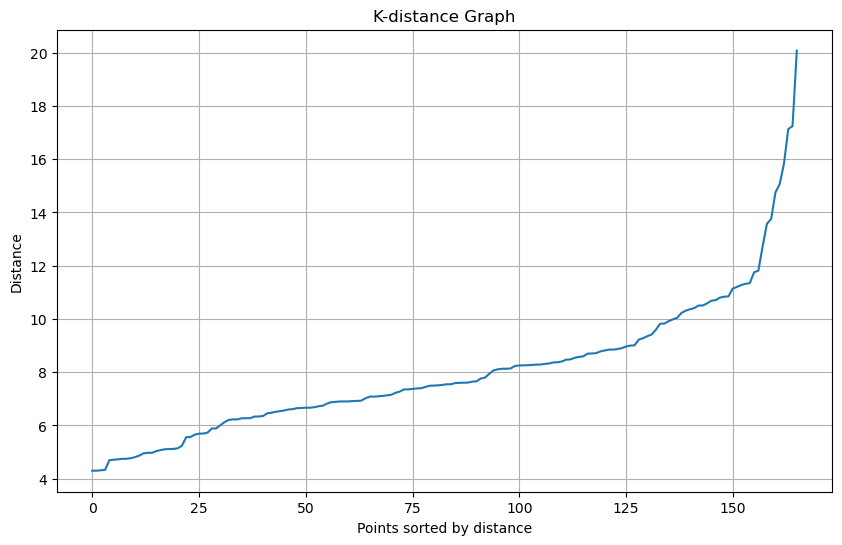

Selected `eps`: 11
Selected `min_samples`: 5


In [59]:
# Cell 7: Determine `eps` and `min_samples` from K-distance Graph
# Plot the K-distance graph to find an appropriate `eps` value for DBSCAN.
from sklearn.neighbors import NearestNeighbors

# Compute the distances to the k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5).fit(df_encoded_scaled)
distances, _ = neighbors.kneighbors(df_encoded_scaled)
distances = np.sort(distances[:, 4], axis=0)

# Plot the K-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("K-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

# Find the index of the "elbow" in the K-distance plot
# This can be done manually by inspecting the plot or using an automated method
elbow_index = np.argmax(np.diff(distances, 2)) + 2  # +2 because of zero-based indexing and first differences

# Set `eps` as the distance at the elbow index
eps = distances[elbow_index]

# For `min_samples`, a common heuristic is to set it slightly larger than the k used in NearestNeighbors
min_samples = 5  # Example value; you may adjust based on the data's density

print(f"Selected `eps`: {eps}")
print(f"Selected `min_samples`: {min_samples}")



In [60]:
# Cell 8: Apply DBSCAN Clustering with Selected Parameters
# Fit DBSCAN to the standardized data using the selected `eps` and `min_samples` values.
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df_encoded_scaled)

# Extract the core clusters (excluding noise)
core_cluster_mask = dbscan_labels != -1
core_cluster_data = df_encoded_scaled[core_cluster_mask]

# Check the number of core clusters
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

if n_clusters > 0:
    print(f"Number of core clusters: {n_clusters}")
else:
    print("No core clusters found by DBSCAN. Skipping KMeans clustering.")
    cluster_src_df['KMeans_Labels'] = np.nan  # Or handle as needed

Number of core clusters: 1


In [61]:
# Cell 9: Apply KMeans Clustering
# Fit KMeans to the core clusters identified by DBSCAN and add the KMeans labels to the original dataframe.
if 'KMeans_Labels' not in cluster_src_df.columns:  # Proceed if KMeans clustering was not skipped
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(core_cluster_data)
    cluster_src_df.loc[core_cluster_mask, 'KMeans_Labels'] = kmeans_labels

C:\Users\Marvin Kassabian\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


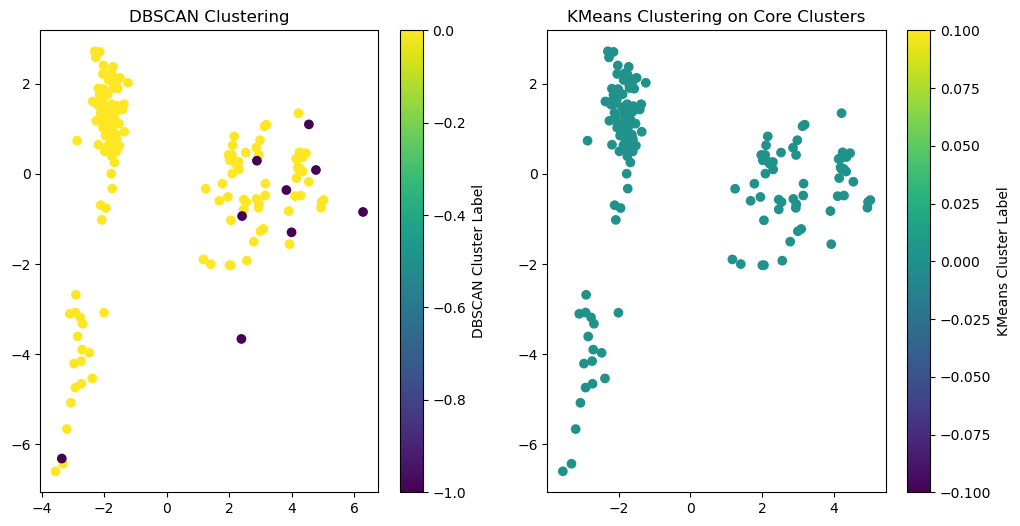

In [62]:
# Cell 10: Visualize the Clustering Results
# Use PCA to reduce dimensionality and visualize the clustering results from both DBSCAN and KMeans.
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded_scaled)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.colorbar(label='DBSCAN Cluster Label')
plt.title("DBSCAN Clustering")

if 'KMeans_Labels' in cluster_src_df.columns:
    plt.subplot(1, 2, 2)
    plt.scatter(df_pca[core_cluster_mask, 0], df_pca[core_cluster_mask, 1], c=kmeans_labels, cmap='viridis', marker='o')
    plt.colorbar(label='KMeans Cluster Label')
    plt.title("KMeans Clustering on Core Clusters")

plt.show()

In [63]:
# Cell 11: Output DataFrame with Clustering Results
# Add the DBSCAN and KMeans clustering results to the original DataFrame.
exercise_2_df['DBSCAN_Labels'] = dbscan_labels

if 'KMeans_Labels' in cluster_src_df.columns:
    exercise_2_df['KMeans_Labels'] = cluster_src_df['KMeans_Labels'].reindex(exercise_2_df.index)

exercise_2_df.head()

exercise_2_df.to_excel('output/Exercise_2_with_clustering_results.xlsx', index=False)